In [1]:
"""CVAE on MNIST
"""
import argparse
import os

import chainer
import pickle
import matplotlib.pyplot as plt
from chainer import training
from chainer.training import extensions
from chainer.training.triggers import EarlyStoppingTrigger
from PIL import Image, ImageDraw
import numpy as np
import cv2

import net 
import make_random_mnist
import make_random_selfdata
from chainer import serializers
%matplotlib inline

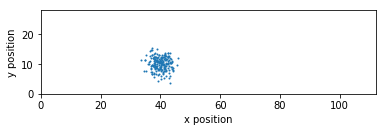

45.72393795010777
15.265786980227361


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

mu = [40, 10]
sigma = [[5, 0], [0, 5]]
values = np.random.multivariate_normal(mu, sigma, 200)
 
# 散布図
ax = plt.gca()
ax.scatter(values[:,0], values[:,1], s=1)
ax.set(ylim=(0,28), ylabel='y position', xlim=(0,28*4), xlabel='x position', aspect='equal')
plt.show()
print(max(values[:,0]))
print(max(values[:,1]))

In [3]:
# Visualize the results
def save_images(x, filename, h= 29, w=113, cols=3,rows=3):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(cols, rows, figsize=(9, 9), dpi=120, edgecolor='coral', linewidth=2)
    for ai, xi in zip(ax.ravel(), x):
        ai.imshow(xi.reshape(h, w))
    ai.set_title(filename)
    fig.savefig(filename)
    plt.show()
    
def plot_images2(data,filename,figsize=(10,6)):
    rows = len(data)
    cols = len(data[0])
    print(cols,rows)
    fig ,ax = plt.subplots(cols,rows,figsize=figsize)
    for r in range(rows):
        if len(data[r]) != cols:
            print(len(data[r]),'!=',rows)
            break
        for c in range(cols):
            ax[c,r].imshow(data[r][c])
    fig.savefig(filename)
    return fig,ax

def save_onehotvec(x):
    plt.plot(x)
    plt.show()
    
def trainMyModel(model, x_train, x_test, options):
    if options.test:
        x_train, _ = chainer.datasets.split_dataset(x_train, 100)
        x_test, _ = chainer.datasets.split_dataset(x_test, 100)
    train_iter = chainer.iterators.SerialIterator(x_train, options.batchsize)
    test_iter = chainer.iterators.SerialIterator(x_test, options.batchsize,repeat=False, shuffle=False)
    
    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Initialize
    if options.initmodel:
        chainer.serializers.load_npz(options.initmodel, model)

    # Set up an updater. StandardUpdater can explicitly specify a loss function
    # used in the training with 'loss_func' option
    updater = training.updaters.StandardUpdater(train_iter, optimizer,device=options.gpu, loss_func=model.get_loss_func(C=10000.0))

    trainer = training.Trainer(updater, (options.epoch, 'epoch'), out=options.out)
    trainer.extend(extensions.Evaluator(test_iter, model, device=options.gpu,eval_func=model.get_loss_func(k=10)))
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(100, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/rec_loss', 'validation/main/rec_loss'],x_key='epoch', file_name='rec_loss.png'))

    if options.resume:
        chainer.serializers.load_npz(options.resume, trainer)

    # Run the training
    trainer.run()
    model.to_cpu()
    serializers.save_npz("mymodel_final.npz", model)
    return model

def testMyModel(model, x_test):
    pass

In [4]:
def load_save_random_dataset_withlabel(fname, n):
    dataset = make_random_mnist.MakeRandomMNIST()
    if os.path.exists(fname):
        with open(fname, mode='rb') as f:
            ret = pickle.load(f)
            return ret
    v = dataset.get_random_dataset_with_label(n)
    with open(fname, mode='wb') as f:
        pickle.dump(v, f)
        return v

def dispImage(img_vec):
    #title = 'Label number is ('+ str(label_x) + ',' + str(label_y) + ')' 
    fig = plt.figure()
    pixels = (img_vec * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.axis("off")
    #plt.title(title)
    plt.show()

def dispOneHotVec(img, vec, vec_size,vec_ratio):
    t_img = img.copy() # cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    #print(np.where(vec==1))
    hotvec = vec.reshape(vec_size)
    #print(hotvec.shape)
    cx, cy = np.where(hotvec == 1)
    #print(cx, cy)
    conv_img_coord_x = (cy*vec_ratio)+14
    conv_img_coord_y = (cx*vec_ratio)+14
    t_img = cv2.circle(t_img, (conv_img_coord_x,conv_img_coord_y), 1, (255, 0, 0), thickness=-1, lineType=cv2.LINE_8, shift=0)
    t_img = cv2.rectangle(t_img, (conv_img_coord_x-14,conv_img_coord_y-14), 
                          (conv_img_coord_x+14,conv_img_coord_y+14), (255,0,0), thickness=0, lineType=cv2.LINE_8, shift=0)
    fig = plt.figure() # Figureオブジェクトを作成
    ax = fig.add_subplot(1,1,1) # figに属するAxesオブジェクトを作成
    plt.imshow(t_img)
    plt.show()
def dispCropPos(img, data, label_vec_size, vec_ratio, color=(248,169,0)):
    t_img = img.copy()
    for n in range(len(data)):
        im, la = data[n]
        #print(la.shape)
        hotvec = la.reshape(label_vec_size)
        cx, cy = np.where(hotvec == 1)
        conv_img_coord_x = (cy*vec_ratio)+14
        conv_img_coord_y = (cx*vec_ratio)+14
        t_img[conv_img_coord_y, conv_img_coord_x] = color
    return t_img

def separetePosition_and_angle_probabilityMap(data, data_len, border):
    angle_map_l = len(data[0]) - border 
    pos_map = np.zeros((data_len, border), dtype=np.float32)
    angle_map = np.zeros((data_len, angle_map_l), dtype=np.float32)
    for n in range(data_len):
        pos_map[n,:] = data[n][0:border]
        angle_map[n,:] = data[n][border:]
    return pos_map, angle_map

In [5]:
def chageBrightness(data, label_vec_size):
    data_num = len(data)
    images = np.zeros((data_num, 28*28), dtype=np.float32)  
    labels = np.zeros((data_num, label_vec_size[0]*label_vec_size[1]), dtype=np.float32)  
    for i in range(data_num):
        img, label = data[i]
        rand_gain = np.random.uniform(-0.3, 0.3, (28*28))
        im = img+rand_gain
        # 0 miman
        im = np.where(im > 1, 1, im)
        # 1 izyou
        im = np.where(im < 0, 0, im)
        images[i, :] = im
        labels[i, :] = label
    return chainer.datasets.TupleDataset(images, labels)

def addGomashio(data, label_vec_size):
    size = 1
    data_num = len(data)
    images = np.zeros((data_num, 28*28), dtype=np.float32)  
    labels = np.zeros((data_num, label_vec_size[0]*label_vec_size[1]), dtype=np.float32)  
    for n in range(data_num):
        x = int(np.random.uniform(0,27))
        y = int(np.random.uniform(0,27))
        c = int(np.random.uniform(0,256))
        img, label = data[n]
        img = (img * 256).reshape((28, 28))
        img = cv2.rectangle(img, (x, y),(x+size,y+size), c, -1)
        img = img.flatten()
        images[n, :] = img/256.
        labels[n, :] = label
    return chainer.datasets.TupleDataset(images, labels)

GPU: 0
# dim z: 1
# Minibatch-size: 500
# epoch: 300

NLABEL 1200
CONDITION 1200
CONTEXT 5701
epoch       main/loss   validation/main/loss  main/rec_loss  validation/main/rec_loss  elapsed_time
1           2710.32     210.551               306.239        210.551                   7.67445       
2           212.902     210.759               212.498        210.759                   12.2943       
3           212.576     209.466               212.311        209.466                   16.9421       
4           210.103     206.717               209.921        206.717                   21.6669       
5           207.69      204.507               207.561        204.507                   26.49         
6           204.86      200.831               204.763        200.831                   31.2945       
7           200.3       194.474               200.224        194.474                   36.0745       
8           193.087     186.933               193.027        186.933                   40.88

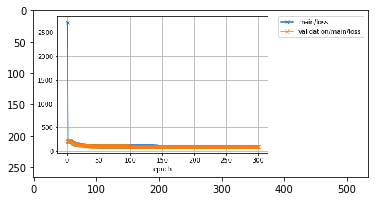

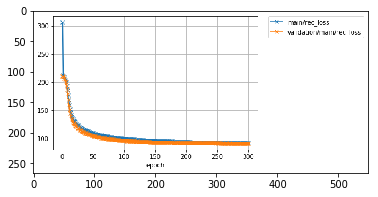

9


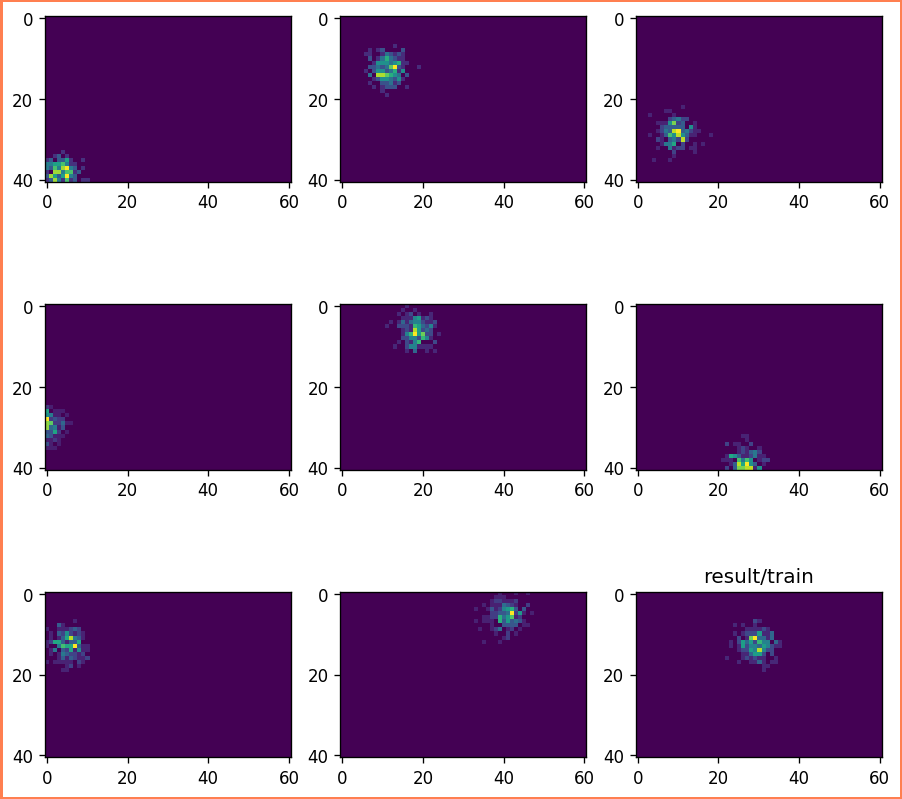

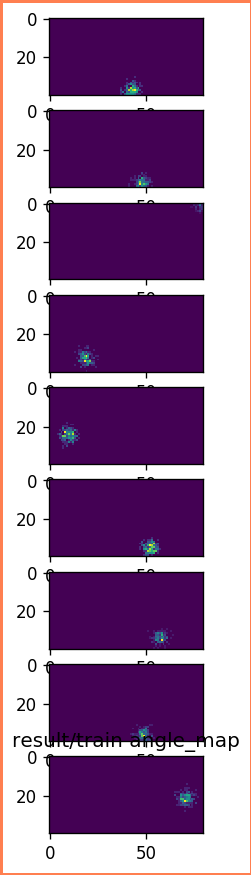

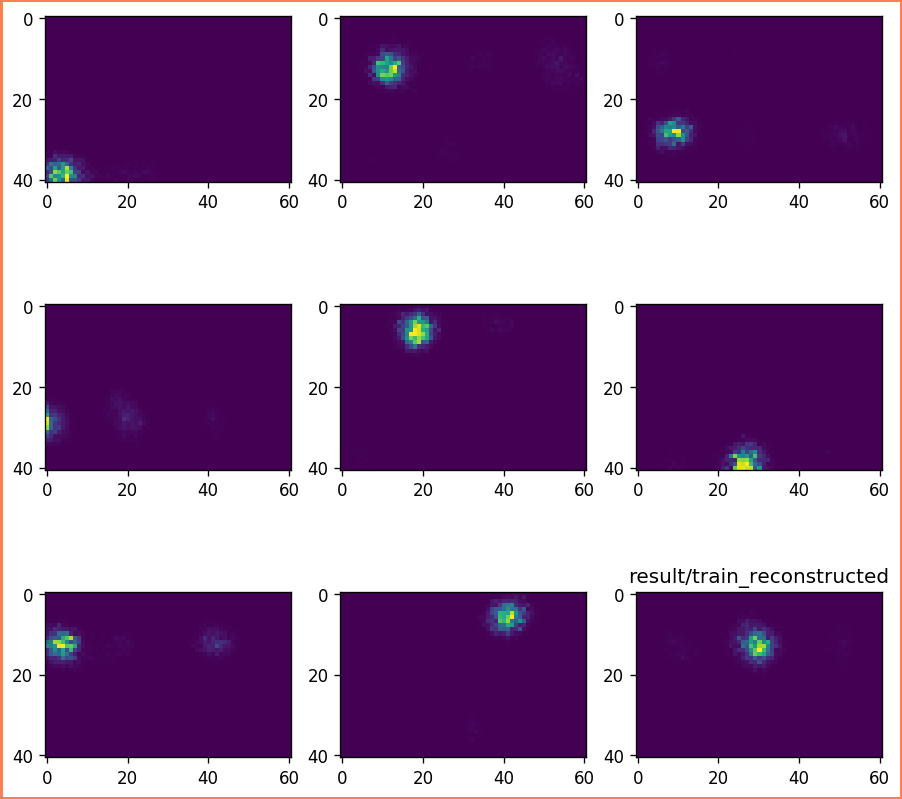

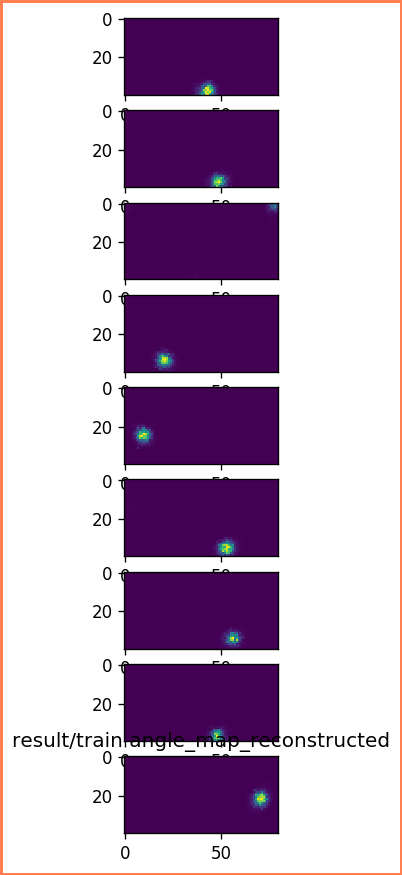

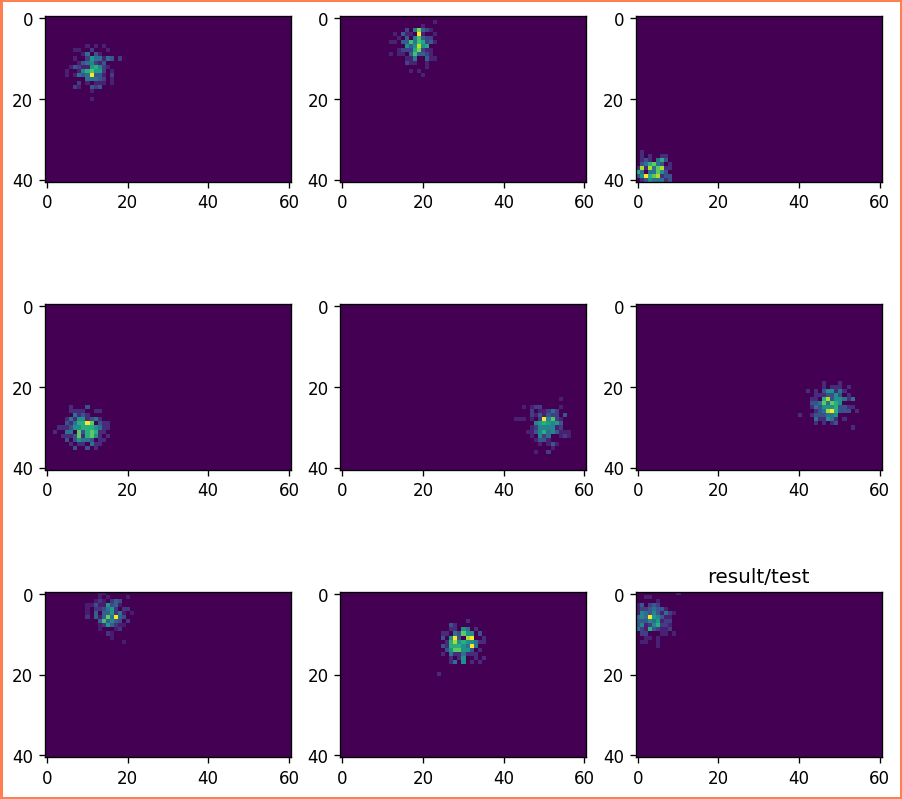

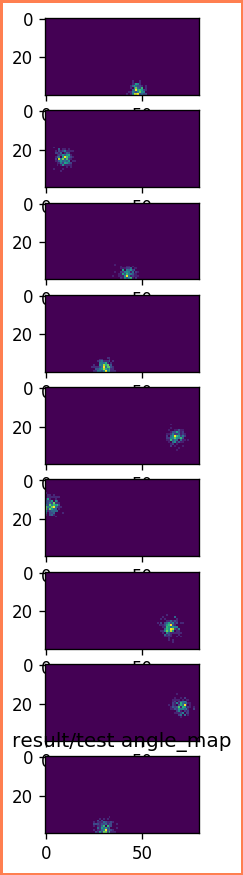

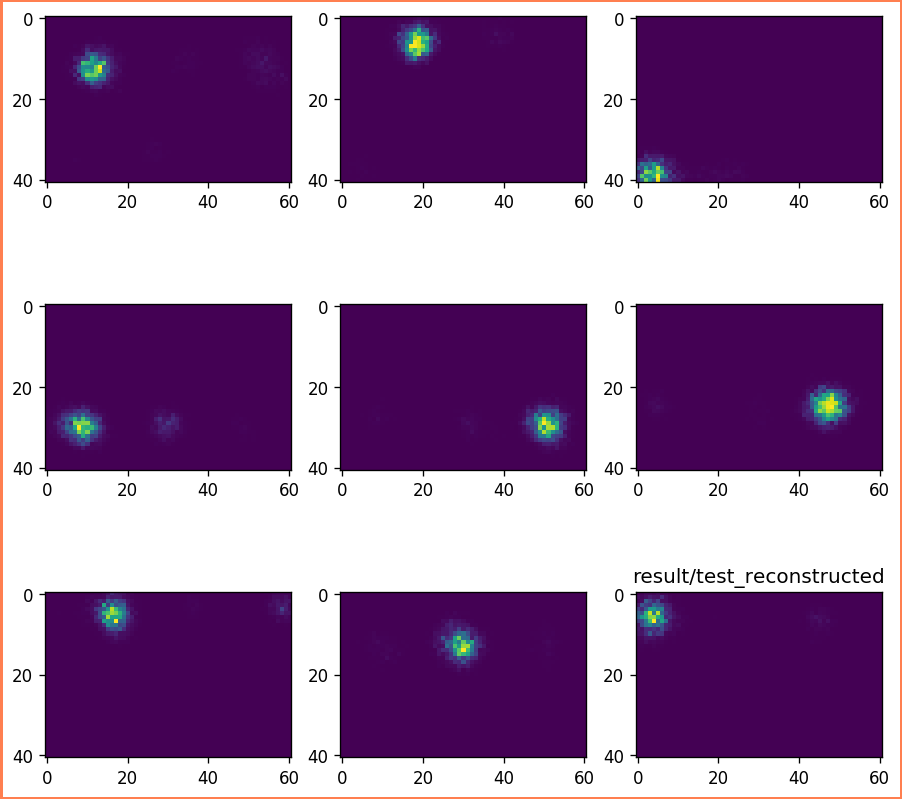

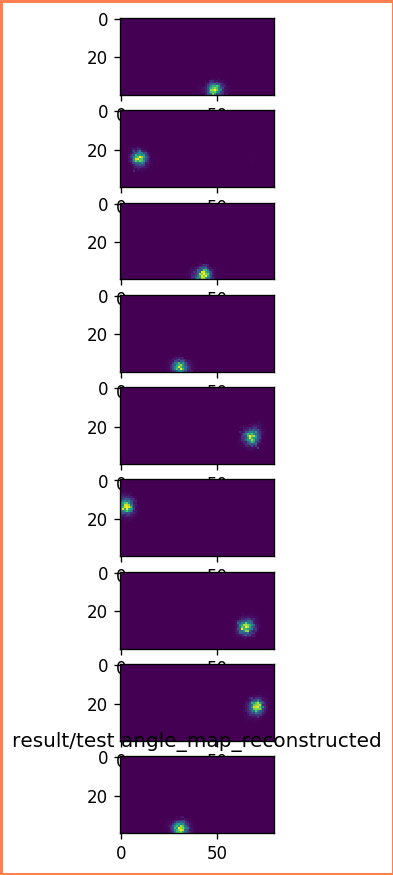

In [6]:
def main():
    global NLABELDIM, NZDIM, HIDDEN
    parser = argparse.ArgumentParser(description='Chainer example: VAE')
    parser.add_argument('--initmodel', '-m', default='',
                        help='Initialize the model from given file')
    parser.add_argument('--resume', '-r', default='',
                        help='Resume the optimization from snapshot')
    parser.add_argument('--gpu', '-g', default=-1, type=int,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--epoch', '-e', default=300, type=int,
                        help='number of epochs to learn')
    parser.add_argument('--dimz', '-z', default=1, type=int,
                        help='dimention of encoded vector')
    parser.add_argument('--batchsize', '-b', type=int, default=500,
                        help='learning minibatch size')
    parser.add_argument('--test', action='store_true',
                        help='Use tiny datasets for quick tests')
    args = parser.parse_args(args=['-g 0'])

    print('GPU: {}'.format(args.gpu))
    print('# dim z: {}'.format(args.dimz))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# epoch: {}'.format(args.epoch))
    print('')

    #img = '../images/chizu_naga.png'
    img = '../images/field_zyouge_sayuu_hanten.png'
    dataset = make_random_selfdata.MakeRandomSelfdata(img)    
    global train,test, train_debug_data, test_debug_data, model
    #train = dataset.get_random_dataset_for_rcvae_with_2d_onehot(3000)
    #test = dataset.get_random_dataset_for_rcvae_with_2d_onehot(3000)
    #for t in range(10):
    #    dispImage(train[t][1])
    
    #train = dataset.get_random_dataset_for_rcvae_with_2d_onehot_and_sincos(3)
    #test = dataset.get_random_dataset_for_rcvae_with_2d_onehot_and_sincos(3) 
    
    #train, train_debug_data = dataset.get_random_dataset_for_rcvae_with_2d_GentleOnehotPosMap_and_2d_GentleOnehotSinCos(60000,0) #40000
    #train, train_debug_data = dataset.get_random_dataset_with_2d_GentleOnehotPosMap_and_2d_GentleOnethot_degVec(60000,0)
    #train = dataset.read_dataset('for_rcvae_with_2d_GentleOnehotPosMap_and_2d_GentleOnehotSinCos_180/train/', 100000, 6477, 28*28)
    #test, test_debug_data = dataset.get_random_dataset_for_rcvae_with_2d_GentleOnehotPosMap_and_2d_GentleOnehotSinCos(1000,1) #3000
    #train = dataset.read_dataset('for_rcvae_with_2d_GentleOnehotPosMap_and_2d_GentleOnethot_degVec_20/train/', 100000, 6337, 28*28)
    #test, test_debug_data = dataset.get_random_dataset_with_2d_GentleOnehotPosMap_and_2d_GentleOnethot_degVec(1000,1) #3000
    
    train, train_debug_data = dataset.get_random_dataset_for_rcvae_with_2d_GentleOnehotPosMap_and_2d_GentleOnehotSinCos_vrepImage(50000, 'simpos_log.csv', 'VrepImage/')
    test, test_debug_data = dataset.get_random_dataset_for_rcvae_with_2d_GentleOnehotPosMap_and_2d_GentleOnehotSinCos_vrepImage(10000, 'simpos_log.csv', 'VrepImage/')
    
    '''
    maps= list(map(lambda x:x[0], train))
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(maps, len(maps), dataset.onehot_w*dataset.onehot_h )
    print(len(angle_map))
    save_images(pos_map, 'train data kakunin of pos map')
    save_images(angle_map, 'train data kakunin of angle map', h=40, w=80,cols=9,rows=1)
    for n in range(9):
        print('訓練データの画像')
        dispImage(train[n][1])
        posx = train_debug_data[n][0].astype(np.int64)
        posy = train_debug_data[n][1].astype(np.int64)
        deg = train_debug_data[n][2].astype(np.int64)
        print(deg, posx-14, posy-14 , 'deg, posx, posy')
        print('回転する前の画像')
        p_im = dataset.getImage(posx, posy)
        dispImage(np.reshape(p_im,(28,28)))
        print('回転した画像')
        r_im, _ = dataset.getRotateImageAndRad(posx, posy, deg)
        dispImage(np.reshape(r_im,(28,28)))
        print('---------------------------')
    '''   
    # Prepare CVAE model, defined in net.py
    NLABELDIM = len(train[0][1])
    CONTEXTDIM = len(train[0][0])
    HIDDEN = 1200
    print('NLABEL', NLABELDIM)
    print('CONDITION', NLABELDIM)
    print('CONTEXT', CONTEXTDIM)
    NZDIM = args.dimz
    
    #print(len(train[0]))
    
    
    
    model = net.MyCVAE(CONTEXTDIM, args.dimz, HIDDEN, NLABELDIM)
    model = trainMyModel(model,train,test,args)
    
    im = Image.open('result/loss.png', 'r')
    plt.imshow(im)
    plt.show()
    im = Image.open('result/rec_loss.png', 'r')
    plt.imshow(im)
    plt.show()
    
    angle_map_h = 40
    angle_map_w = 80
    train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
    xin = np.empty((0, CONTEXTDIM), np.float32)
    xout = np.empty((0, CONTEXTDIM), np.float32)
    for ind in train_ind:
        x, t = train[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xin, len(xin), dataset.vrep_onehot_w* dataset.vrep_onehot_h)
    print(len(angle_map))
    save_images(pos_map, os.path.join(args.out, 'train'), h=dataset.vrep_onehot_h, w=dataset.vrep_onehot_w)
    save_images(angle_map, os.path.join(args.out,'train angle_map'), h=angle_map_h, w=angle_map_w,cols=9,rows=1)

    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xout, len(xout), dataset.vrep_onehot_w* dataset.vrep_onehot_h)
    save_images(pos_map, os.path.join(args.out, 'train_reconstructed'), h=dataset.vrep_onehot_h, w=dataset.vrep_onehot_w)
    save_images(angle_map, os.path.join(args.out, 'train angle_map_reconstructed'), h=angle_map_h, w=angle_map_w,cols=9,rows=1)
    
    test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
    xin = np.empty((0, CONTEXTDIM), np.float32)
    xout = np.empty((0, CONTEXTDIM), np.float32)
    for ind in test_ind:
        x, t = test[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xin, len(xin), dataset.vrep_onehot_w* dataset.vrep_onehot_h)
    save_images(pos_map, os.path.join(args.out, 'test'), h=dataset.vrep_onehot_h, w=dataset.vrep_onehot_w)
    save_images(angle_map, os.path.join(args.out, 'test angle_map'), h=angle_map_h, w=angle_map_w,cols=9,rows=1)
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xout, len(xout), dataset.vrep_onehot_w* dataset.vrep_onehot_h)
    save_images(pos_map, os.path.join(args.out, 'test_reconstructed'), h=dataset.vrep_onehot_h, w=dataset.vrep_onehot_w)
    save_images(angle_map, os.path.join(args.out,'test angle_map_reconstructed'), h=angle_map_h, w=angle_map_w,cols=9,rows=1)
    
    # 訓練のログデータを残す部分
    log_data = str(args.epoch)+ ', '+ str(args.batchsize)+ ', '+str(args.dimz) +','+ str(dataset.rotation_angle) + ',' + str(NLABELDIM)+ ',' +str(CONTEXTDIM)+ ',' +str(HIDDEN)
    f = open('training_data.log', 'w')
    f.write(log_data)
    f.close()
if __name__ == '__main__':
    main()

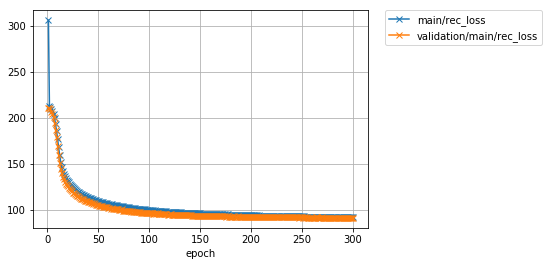

In [7]:
from IPython.display import Image
Image('result/loss.png')
Image('result/rec_loss.png')

testデータの画像
68 22 69
testデータの画像
68 45 85
testデータの画像
20 14 139
testデータの画像
29 24 77
testデータの画像
55 14 43
testデータの画像
53 34 0
testデータの画像
52 47 171
testデータの画像
60 14 177
testデータの画像
48 35 158
testデータの画像
57 30 63
10 5


(<Figure size 1440x2160 with 50 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf79887780>,
       dtype=object))

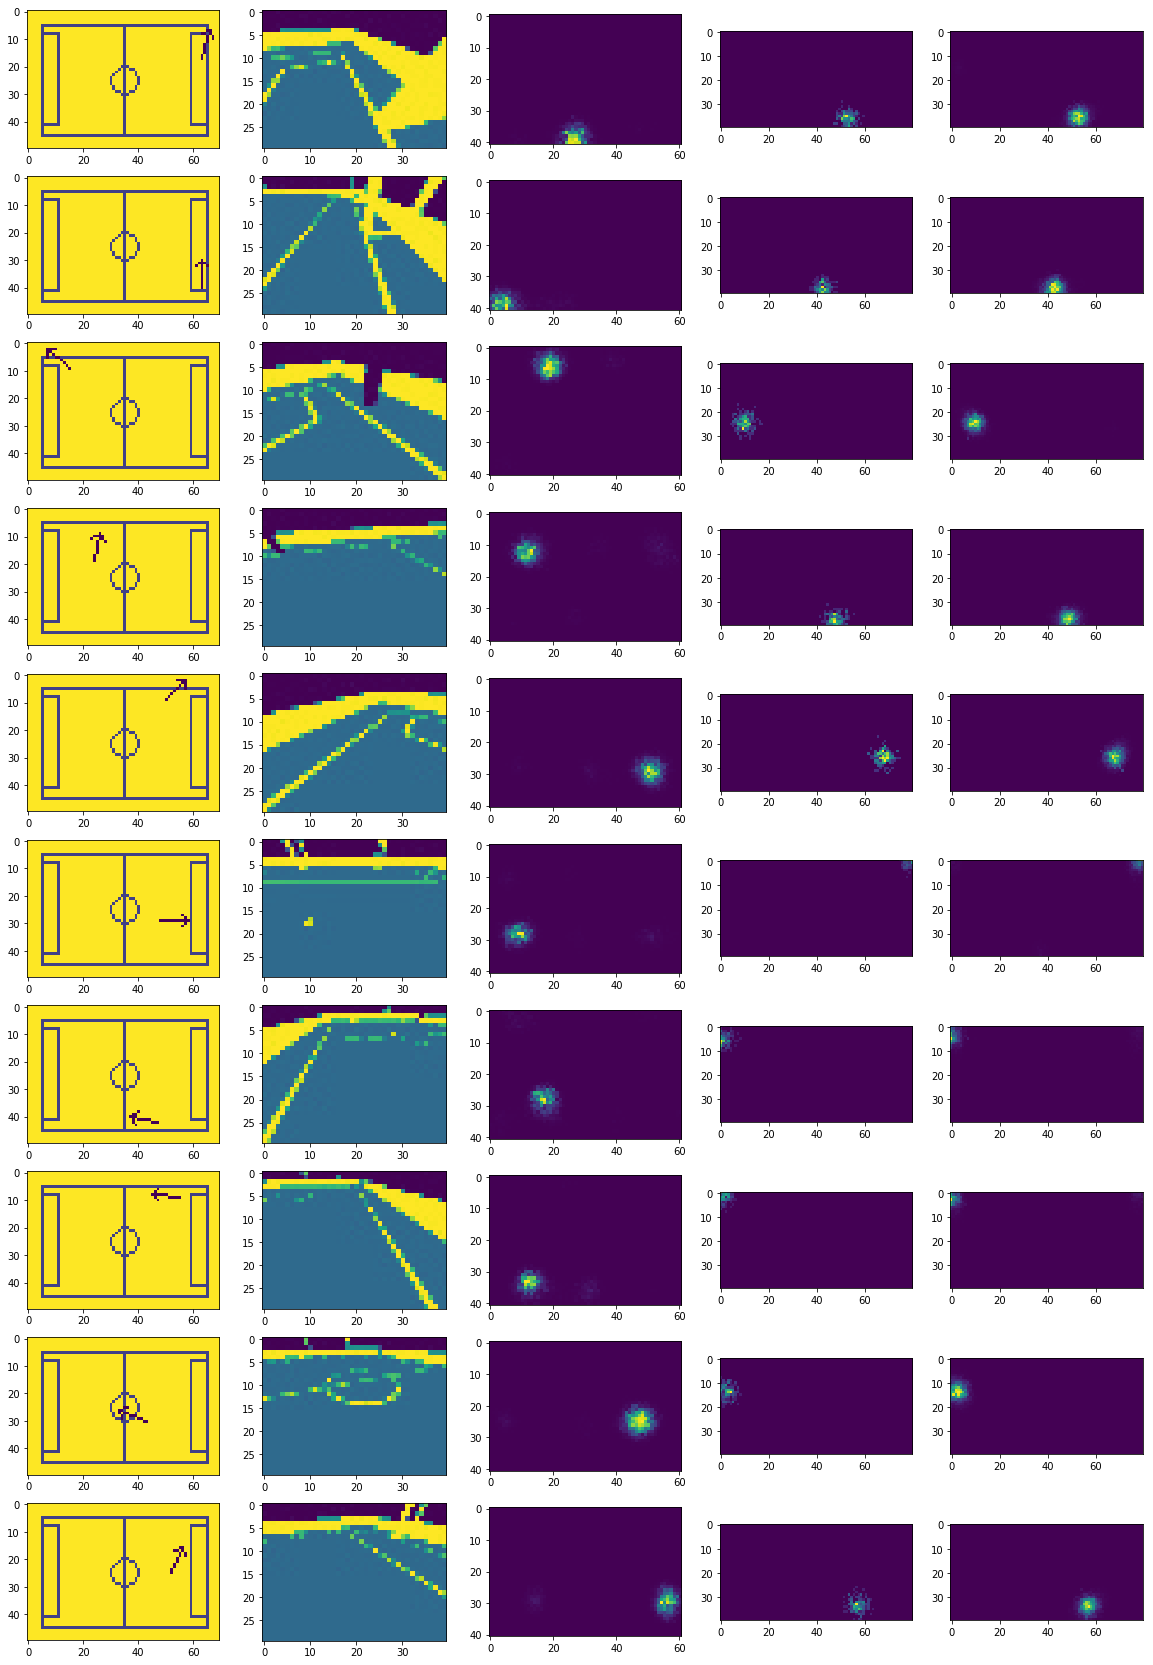

In [8]:
angle_map_h = 40
angle_map_w = 80

img = '../images/field_zyouge_sayuu_hanten.png'
dataset = make_random_selfdata.MakeRandomSelfdata(img)
test, test_debug_data = dataset.get_random_dataset_for_rcvae_with_2d_GentleOnehotPosMap_and_2d_GentleOnehotSinCos_vrepImage(100, 'simpos_log.csv', 'VrepImage/')

NZDIM = 1
NLABELDIM = len(test[0][1])
CONTEXTDIM = len(test[0][0])
HIDDEN = 1200
img_m = 10
#model = net.MyCVAE(CONTEXTDIM, NZDIM, HIDDEN, NLABELDIM)
#serializers.load_npz("vrep_weight/mymodel_final.npz", model)

onehot_size = dataset.getOnehotSize()

angles = np.zeros((10, angle_map_h*angle_map_w), dtype=np.float32)
images = np.zeros((10, 40*30), dtype=np.float32)###################### 画像の大きさ変わってるから！！！！
hukan = np.zeros((10, 50,70), dtype=np.float32)
z = chainer.Variable(np.zeros((10, 1), dtype=np.float32))

# テストデータに含まれてた座標で生成する
position = np.zeros((10, dataset.onehot_w*dataset.onehot_h ), dtype=np.float32)
ya_l = 10
for n in range(10):
    print('testデータの画像')
    posx = test_debug_data[n][0].astype(np.int64)
    posy = int(dataset.field_h/dataset.vrep_image_ratio) - test_debug_data[n][1].astype(np.int64)
    deg = test_debug_data[n][2].astype(np.int64)
    print(posx+img_m, posy+img_m, deg)
    angles[n,:] = dataset.make_angle_map(deg)
    field_img = cv2.imread('green.png',0)
    ya_x = ya_l*np.cos(np.deg2rad(deg)) ##
    ya_y = ya_l*(np.sin(np.deg2rad(-deg))) ##画像上の座標にして
    cv2.arrowedLine(field_img, (posx+int(img_m/2), posy+int(img_m/2)), (int(ya_x+int(img_m/2)+posx), int(ya_y+int(img_m/2)+posy)), (0, 255, 0), thickness=1, tipLength=0.3)
    
    hukan[n,:] = field_img
    images[n,:] = test[n][1]
values = images

with chainer.using_config('train', False), chainer.no_backprop_mode():
    x = model.decode(z, np.expand_dims(values, axis=1))
pos_map, angle_map = separetePosition_and_angle_probabilityMap(x.data, len(x.data), dataset.vrep_onehot_w* dataset.vrep_onehot_h)
#save_images(pos_map, 'reconstracted_t_pos_map', h=dataset.vrep_onehot_h, w=dataset.vrep_onehot_w)
#save_images(angle_map, 'reconstracted_t_angle_map',h=angle_map_h, w=angle_map_w,cols=9,rows=1)

plot_images2((hukan, np.reshape(images,(10,30,40)), np.reshape(pos_map,(10,dataset.vrep_onehot_h,dataset.vrep_onehot_w)), np.reshape(angles,(10,angle_map_h,angle_map_w)), np.reshape(angle_map,(10,angle_map_h,angle_map_w))), "genarated_image_from_condition.png", figsize=(20,30))